# Propagation

> Scripts to propagate the orbits

*Propagation implemented by Walther Litteri*

In [53]:
#| default_exp propagation

In [54]:
#| export
#| hide
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from typing import Tuple, List, Dict, Optional

In [55]:
#| test
#| hide
from orbit_generation.data import get_example_orbit_data
from orbit_generation.visualize import visualize_static_orbits
from orbit_generation.constants import EM_MU

## Tolerance Constants

In [56]:
#| export
RELATIVE_TOLERANCE = 1e-8
ABSOLUTE_TOLERANCE = 1e-8

## Jacobi Constant

In [57]:
# | export
def jacobi_constant(X: np.ndarray,  # Cartesian state vector with 6 components (x, y, z, xp, yp, zp)
                    mu: float  # Gravitational parameter
                   ) -> Tuple[float, float]:
    """
    State-dependent Jacobi constant for a given state vector X and gravitational parameter mu.

    Parameters:
    X (np.ndarray): Cartesian state vector with 6 components (x, y, z, xp, yp, zp).
    mu (float): Gravitational parameter.

    Returns:
    Tuple[float, float]: Jacobi constant (J) and total energy (E).
    """
    if len(X) != 6:
        raise TypeError("Define a state vector of length 6")

    # Unpack state vector components
    x, y, z, xp, yp, zp = X
    
    # Compute distances to the primary and secondary bodies
    mu1 = 1 - mu
    mu2 = mu
    r1 = np.sqrt((x + mu2)**2 + y**2 + z**2)
    r2 = np.sqrt((x - mu1)**2 + y**2 + z**2)

    # Calculate kinetic energy
    K = 0.5 * (xp**2 + yp**2 + zp**2)

    # Calculate the effective potential energy
    Ubar = -0.5 * (x**2 + y**2) - mu1 / r1 - mu2 / r2 - 0.5 * mu1 * mu2
    # Note: The last term is not used in the NASA database for the Jacobi constant computation. We adopt the complete convention.

    # Total energy
    E = K + Ubar

    # Jacobi constant
    J = -2 * E

    return J, E

In [58]:
# | test
orbit_data = get_example_orbit_data()
orbit_data.shape

(200, 6, 300)

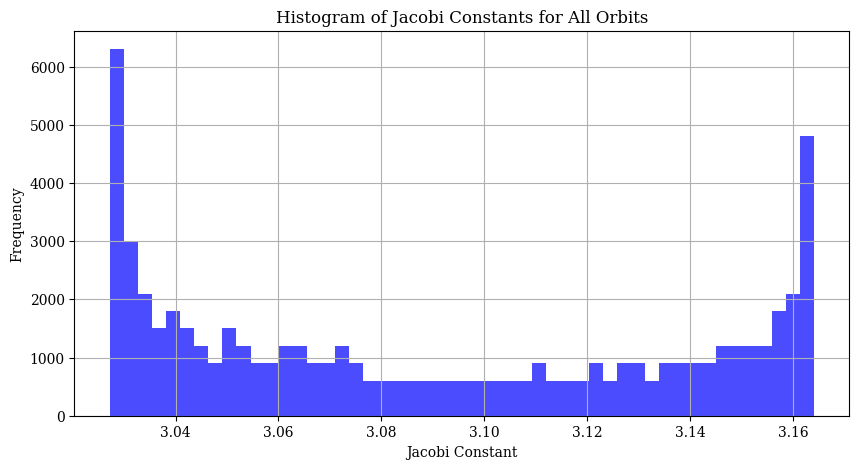

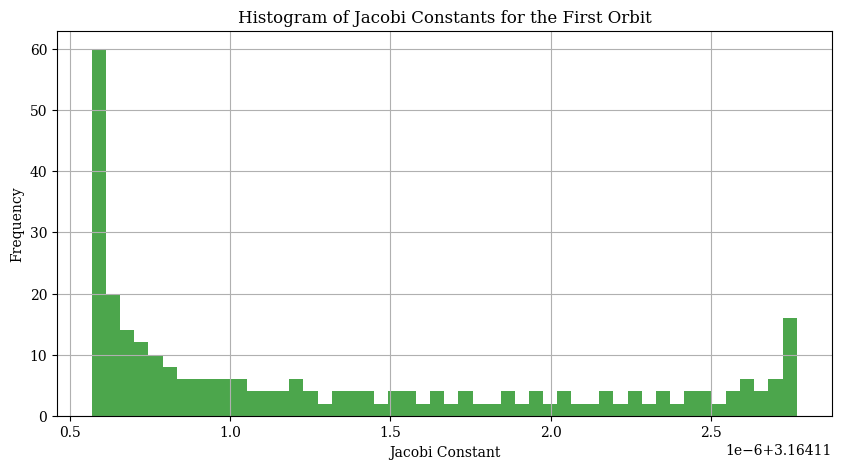

In [59]:
# | test jacobi_constant
# Calculate Jacobi constants and energies for all orbits at all time points
jacobi_constants = np.zeros((200, 300))
total_energies = np.zeros((200, 300))

for orbit_index in range(200):
    for time_index in range(300):
        X = orbit_data[orbit_index, :, time_index]
        J, E = jacobi_constant(X, EM_MU)
        jacobi_constants[orbit_index, time_index] = J
        total_energies[orbit_index, time_index] = E

# Flatten the Jacobi constants array to plot the histogram of all values
jacobi_constants_all = jacobi_constants.flatten()

# Plot histogram of Jacobi constants for all orbits
plt.figure(figsize=(10, 5))
plt.hist(jacobi_constants_all, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Jacobi Constants for All Orbits')
plt.xlabel('Jacobi Constant')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histogram of Jacobi constants for the first orbit
jacobi_constants_first_orbit = jacobi_constants[0, :]

plt.figure(figsize=(10, 5))
plt.hist(jacobi_constants_first_orbit, bins=50, color='green', alpha=0.7)
plt.title('Histogram of Jacobi Constants for the First Orbit')
plt.xlabel('Jacobi Constant')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Equations of motion CR3BP

In [60]:
# | export
def eom_cr3bp(t: float,  # Time variable (not used in this formulation)
              X: np.ndarray,  # State vector with 6 components (x, y, z, v_x, v_y, v_z)
              mu: float  # Gravitational parameter
             ) -> List[float]:
    """
    Equations of motion for the Circular Restricted 3 Body Problem (CR3BP). 
    The form is X_dot = f(t, X, (parameters,)). This formulation is time-independent 
    as it does not depend explicitly on t.
    
    Parameters:
    t (float): Time variable (not used in this formulation).
    X (np.ndarray): State vector with 6 components (x, y, z, v_x, v_y, v_z).
    mu (float): Gravitational parameter.

    Returns:
    List[float]: Derivatives of the state vector.
    """
    
    # Unpack state vector components
    x, y, z, v_x, v_y, v_z = X

    # Position of spacecraft with respect to primary bodies
    r1 = np.sqrt((x + mu)**2 + y**2 + z**2)
    r2 = np.sqrt((x - (1 - mu))**2 + y**2 + z**2)
    
    # State ODE:
    x_dot  = v_x
    y_dot  = v_y
    z_dot  = v_z
    x_ddot = x + 2 * v_y - (1 - mu) * (x + mu) / r1**3 - mu * (x - (1 - mu)) / r2**3
    y_ddot = y - 2 * v_x - y * ((1 - mu) / r1**3 + mu / r2**3)
    z_ddot = -z * ((1 - mu) / r1**3 + mu / r2**3)

    # Return the state derivatives as a list
    Xdot = [x_dot, y_dot, z_dot, x_ddot, y_ddot, z_ddot]
   
    return Xdot

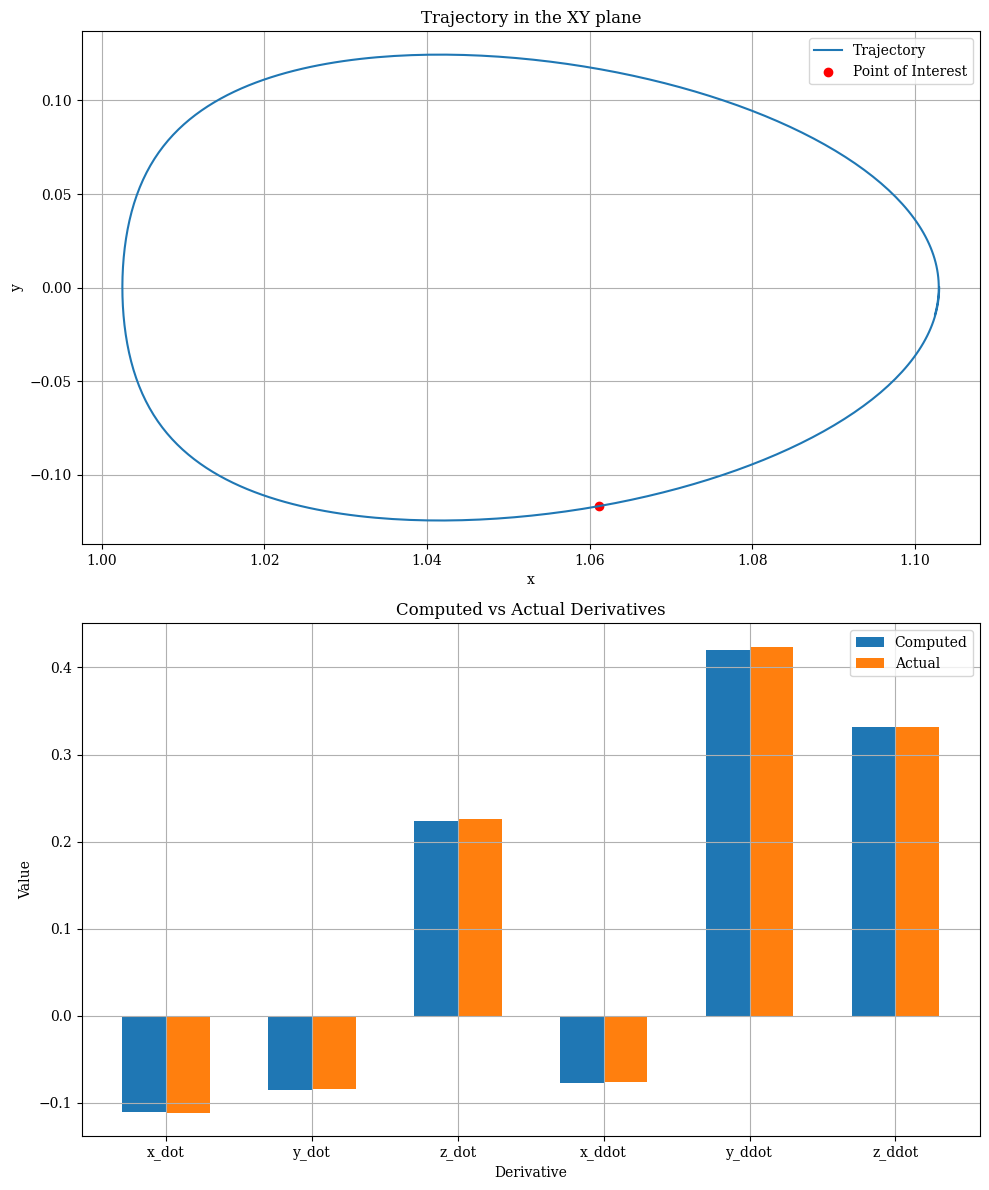

In [61]:
#| test eom_cr3bp

# Select a random orbit from the dataset
num_orbits, num_components, num_time_points = orbit_data.shape
random_orbit_index = np.random.randint(0, num_orbits)
X0 = orbit_data[random_orbit_index, :, 0]
mu = 0.01215058560962404
T0 = 2.7430007981241529E+0  # Total time for the propagation, can be adjusted as needed

# Propagate the orbit using solve_ivp
sol = solve_ivp(eom_cr3bp, [0, T0], X0, args=(mu,), dense_output=True, rtol=1e-9, atol=1e-9, method='Radau')
tvec = np.linspace(0, T0, num_time_points)
z = sol.sol(tvec)

# Compute derivatives using eom_cr3bp for a specific state in the propagated orbit
time_index = np.random.randint(0, num_time_points - 1)  # Choose a random time index
t = tvec[time_index]
X = z[:, time_index]
computed_derivatives = eom_cr3bp(t, X, mu)

# Compare with actual changes in state vector
delta_t = tvec[1] - tvec[0]
actual_derivatives = (z[:, time_index + 1] - z[:, time_index]) / delta_t

# Visualize the actual trajectory and computed derivatives
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot the actual trajectory
axs[0].plot(z[0], z[1], label='Trajectory')
axs[0].scatter(z[0, time_index], z[1, time_index], color='red', label='Point of Interest')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Trajectory in the XY plane')
axs[0].legend()
axs[0].grid(True)

# Plot computed vs. actual derivatives
labels = ['x_dot', 'y_dot', 'z_dot', 'x_ddot', 'y_ddot', 'z_ddot']
width = 0.3  # width of the bars
x = np.arange(len(labels))  # the label locations

axs[1].bar(x - width/2, computed_derivatives, width, label='Computed')
axs[1].bar(x + width/2, actual_derivatives, width, label='Actual')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels)
axs[1].set_xlabel('Derivative')
axs[1].set_ylabel('Value')
axs[1].set_title('Computed vs Actual Derivatives')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Propagation

In [62]:
# | export
def prop_node(X: np.ndarray,  # Initial state vector with 6 components (x, y, z, v_x, v_y, v_z)
              dt: float,  # Time step for propagation
              mu: float  # Gravitational parameter
             ) -> np.ndarray:
    """
    Return the state X after a given time step dt = T_end - T_start.
    
    Parameters:
    X (np.ndarray): Initial state vector with 6 components (x, y, z, v_x, v_y, v_z).
    dt (float): Time step for propagation.
    mu (float): Gravitational parameter.
    
    Returns:
    np.ndarray: Final state vector after time step dt.
    """
    # Solve the initial value problem using the eom_cr3bp function
    sol = solve_ivp(
        eom_cr3bp, [0, dt], X, args=(mu,), dense_output=True,
        rtol=RELATIVE_TOLERANCE, atol=ABSOLUTE_TOLERANCE, method='Radau'
    )
    
    # Return the final state vector
    return sol.y.T[-1]

Initial state vector: [ 1.09848208  0.         -0.19956776  0.         -0.21469097  0.        ]
Final state vector after time step dt: [ 1.09744623 -0.02137444 -0.19786112 -0.02067228 -0.21185033  0.03413507]


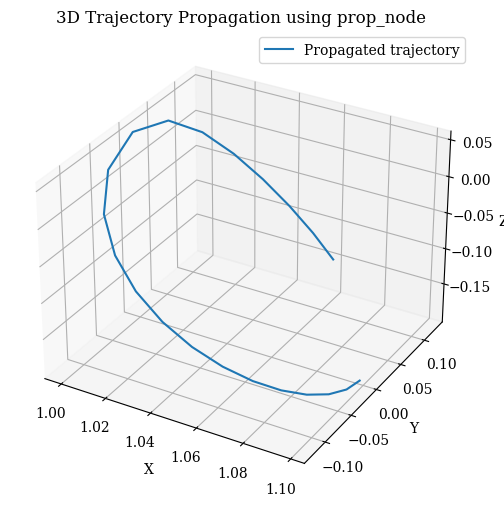

In [63]:
#| test prop_node

# Select a random orbit from the dataset
num_orbits, num_components, num_time_points = orbit_data.shape
random_orbit_index = np.random.randint(0, num_orbits)
X0 = orbit_data[random_orbit_index, :, 0]
mu = 0.01215058560962404
dt = 0.1  # Small time step for propagation

# Propagate the state vector using prop_node
X_final = prop_node(X0, dt, mu)

# Print the initial and final state vectors
print("Initial state vector:", X0)
print("Final state vector after time step dt:", X_final)

# To visualize the propagation, we can propagate over multiple time steps and plot the trajectory
T_total = 2.0  # Total time for propagation
time_steps = int(T_total / dt)
trajectory = np.zeros((time_steps + 1, 6))
trajectory[0] = X0

# Propagate step by step
X_current = X0
for i in range(1, time_steps + 1):
    X_current = prop_node(X_current, dt, mu)
    trajectory[i] = X_current

# Plot the trajectory
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='Propagated trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectory Propagation using prop_node')
ax.legend()
plt.show()

## Compute Error

In [64]:
# | export
def jacobi_test(X: np.ndarray,  # State vector with shape (n, 6) or (n, 7), where n is the number of samples
                mu: float  # Gravitational parameter
               ) -> float:
    """
    Compute the energy error. X can have either 6 columns (state vector) or 7 columns (time + state vector).
    The returned quantity is the cumulative error with respect to the initial value. If propagation is perfect, err = 0 (or very small).
    
    Parameters:
    X (np.ndarray): State vector with shape (n, 6) or (n, 7), where n is the number of samples.
    mu (float): Gravitational parameter.
    
    Returns:
    float: Cumulative energy error with respect to the initial value.
    """
    n, k = np.shape(X)
    
    # Initial Jacobi constant
    J0 = jacobi_constant(X[0, (k-6):k], mu)[0]
    
    err = 0.0
    # Compute cumulative error
    for i in range(n):
        Ji = jacobi_constant(X[i, (k-6):k], mu)[0]
        err += np.abs(J0 - Ji)
    
    return err

In [65]:
# | export
def dynamics_defect(X: np.ndarray,  # Time-state vector with shape (n, 7), where the first column is the time vector
                    mu: float  # Gravitational parameter
                   ) -> Tuple[float, float]:
    """
    Compute the dynamical defect for the generated time-state sequence. 
    The returned quantity is the cumulative error on the position and velocity components.
    The overall metrics can be a combination of these two last errors.
    
    Parameters:
    X (np.ndarray): Time-state vector with shape (n, 7), where the first column is the time vector.
    mu (float): Gravitational parameter.
    
    Returns:
    Tuple[float, float]: Cumulative errors in position and velocity.
    """
    n, m = np.shape(X)
    if m != 7:
        raise TypeError("X must be of size (n, 7). The first column is the time vector.")
    
    errX = 0.0  # Error in the position vector
    errV = 0.0  # Error in the velocity vector

    for i in range(n - 1):
        X_start = X[i, 1:7]
        X_end = X[i + 1, 1:7]
        dt = X[i + 1, 0] - X[i, 0]
        X_test = prop_node(X_start, dt, mu)
        err = X_test - X_end

        errX += np.linalg.norm(err[0:3])
        errV += np.linalg.norm(err[3:6])
    
    return errX, errV

Cumulative energy error for the selected orbit: 0.00024021174270538737
Cumulative position error for the selected orbit: 0.08454711062303778
Cumulative velocity error for the selected orbit: 0.16099501473259373


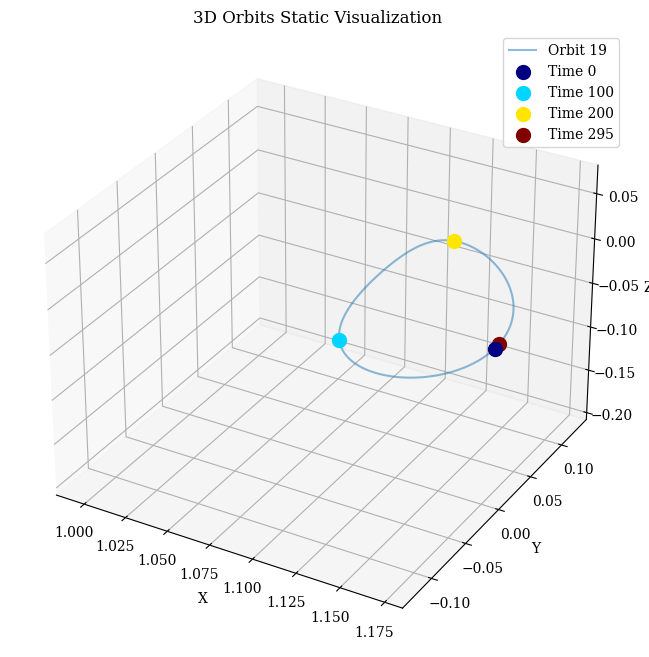

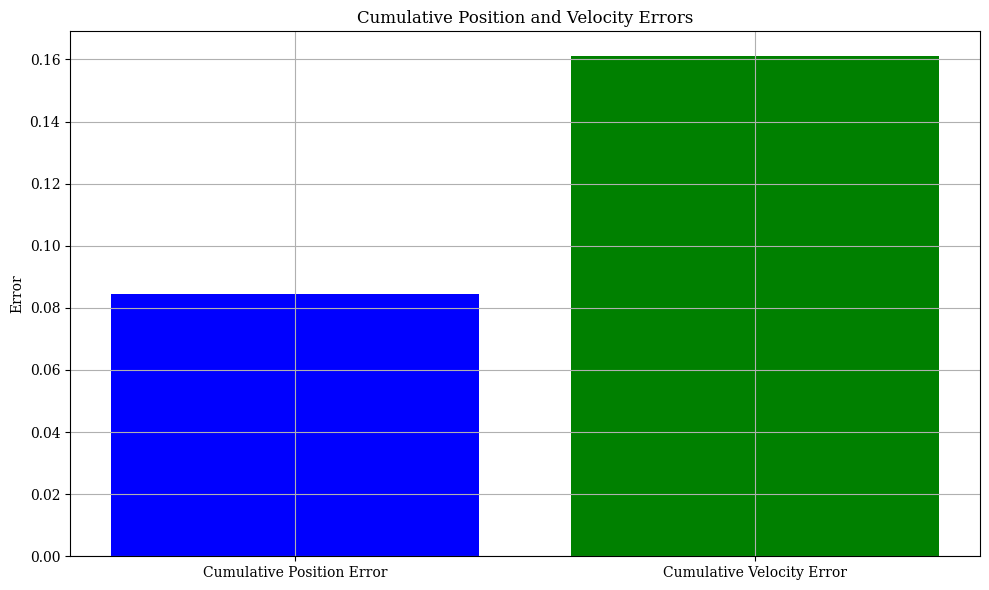

In [66]:
#| test dynamics_defect

# Select a random orbit from the dataset
num_orbits, num_components, num_time_points = orbit_data.shape
random_orbit_index = np.random.randint(0, num_orbits)
selected_orbit = orbit_data[random_orbit_index, :, :]

# Add a time column to the state vector for dynamics_defect function
# Assuming the time steps are evenly spaced and given by the array tvec
tvec = np.linspace(0, 2.7430007981241529E+0, num_time_points)
time_state_vector = np.hstack((tvec.reshape(-1, 1), selected_orbit.T))

# Test jacobi_test function
energy_error = jacobi_test(selected_orbit.T, mu)
print("Cumulative energy error for the selected orbit:", energy_error)

# Test dynamics_defect function
pos_error, vel_error = dynamics_defect(time_state_vector, mu)
print("Cumulative position error for the selected orbit:", pos_error)
print("Cumulative velocity error for the selected orbit:", vel_error)

# Visualize the numerically propagated orbit
visualize_static_orbits(orbit_data, time_instants=[0, 100, 200, 295], orbit_indices=[random_orbit_index])

# Visualize the cumulative errors calculated
fig, ax = plt.subplots(figsize=(10, 6))

labels = ['Cumulative Position Error', 'Cumulative Velocity Error']
errors = [pos_error, vel_error]

ax.bar(labels, errors, color=['blue', 'green'])
ax.set_ylabel('Error')
ax.set_title('Cumulative Position and Velocity Errors')
ax.grid(True)

plt.tight_layout()
plt.show()

In [67]:
# | export
def calculate_errors(orbit_data: np.ndarray,  # 3D array of orbit data
                     mu: float,  # Gravitational parameter
                     orbit_indices: List[int] = None,  # List of integers referring to the orbits to analyze
                     error_types: List[str] = ['position', 'velocity', 'energy'],  # Types of errors to calculate
                     time_step: Optional[float] = None,  # Optional time step if time dimension is not included
                     display_results: bool = True  # Boolean to control whether to display the results
                    ) -> Dict[str, Tuple[float, float]]:
    """
    Calculate and return the cumulative error and the average error per time step
    for the selected orbits together. Optionally, display the evolution of each error as a chart.
    
    Parameters:
    orbit_data (np.ndarray): 3D array of orbit data.
    mu (float): Gravitational parameter.
    orbit_indices (List[int], optional): List of integers referring to the orbits to analyze. 
                                         If None, analyze all orbits. Default is None.
    error_types (List[str]): List of types of errors to calculate: 'position', 'velocity', and/or 'energy'.
    time_step (float, optional): Optional time step if time dimension is not included. Default is None.
    display_results (bool, optional): Whether to display the results as charts. Default is True.
    
    Returns:
    Dict[str, Tuple[float, float]]: A dictionary with keys being the error types and values being
                                     tuples of cumulative error and average error per time step.
    """
    if orbit_indices is None:
        orbit_indices = list(range(orbit_data.shape[0]))

    # Check if the time dimension is included in the data
    if orbit_data.shape[1] == 6 and time_step is not None:
        num_time_points = orbit_data.shape[2]
        tvec = np.linspace(0, num_time_points * time_step, num_time_points + 1)
        orbit_data_with_time = np.zeros((orbit_data.shape[0], 7, num_time_points))
        orbit_data_with_time[:, 1:, :] = orbit_data
        for i in range(num_time_points):
            orbit_data_with_time[:, 0, i] = tvec[i]
        orbit_data = orbit_data_with_time
    elif orbit_data.shape[1] != 7:
        raise ValueError("Invalid orbit_data shape. Must be (n, 6, m) or (n, 7, m)")

    errors = {}
    
    for error_type in error_types:
        cumulative_error = 0.0
        error_evolution = np.zeros(orbit_data.shape[2] - 1)
        
        for idx in orbit_indices:
            selected_orbit = orbit_data[idx, :, :].T  # Transpose to shape (num_time_points, 7)
            tvec = selected_orbit[:, 0]  # Time vector for the current orbit

            # Ensure the time vector is strictly increasing
            if not np.all(np.diff(tvec) > 0):
                raise ValueError("Time vector is not strictly increasing.")

            if error_type == 'position':
                pos_error, _ = dynamics_defect(selected_orbit, mu)
                cumulative_error += pos_error
                for i in range(len(tvec) - 1):
                    dt = tvec[i + 1] - tvec[i]
                    X_start = selected_orbit[i, 1:]
                    X_end = selected_orbit[i + 1, 1:]
                    X_test = prop_node(X_start, dt, mu)
                    error_evolution[i] += np.linalg.norm(X_test[:3] - X_end[:3])
                    
            elif error_type == 'velocity':
                _, vel_error = dynamics_defect(selected_orbit, mu)
                cumulative_error += vel_error
                for i in range(len(tvec) - 1):
                    dt = tvec[i + 1] - tvec[i]
                    X_start = selected_orbit[i, 1:]
                    X_end = selected_orbit[i + 1, 1:]
                    X_test = prop_node(X_start, dt, mu)
                    error_evolution[i] += np.linalg.norm(X_test[3:] - X_end[3:])
                    
            elif error_type == 'energy':
                energy_error = jacobi_test(selected_orbit[:, 1:], mu)
                cumulative_error += energy_error
                for i in range(len(tvec) - 1):
                    Ji_start = jacobi_constant(selected_orbit[i, 1:], mu)[0]
                    Ji_end = jacobi_constant(selected_orbit[i + 1, 1:], mu)[0]
                    error_evolution[i] += np.abs(Ji_start - Ji_end)
                    
            else:
                raise ValueError("Invalid error type. Choose from 'position', 'velocity', or 'energy'.")
        
        avg_error_per_timestep = cumulative_error / (orbit_data.shape[2] - 1)
        
        if display_results:
            print(f"Cumulative {error_type} error for selected orbits: {cumulative_error}")
            print(f"Average {error_type} error per time step: {avg_error_per_timestep}")
            
            # Display the error evolution as a chart
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(error_evolution)), error_evolution, label=f'{error_type.capitalize()} Error Evolution')
            plt.xlabel('Timestep Index')
            plt.ylabel(f'{error_type.capitalize()} Error')
            plt.title(f'{error_type.capitalize()} Error Evolution Over Timesteps')
            plt.legend()
            plt.grid(True)
            plt.show()
        
        errors[error_type] = (cumulative_error, avg_error_per_timestep)
    
    return errors

Cumulative position error for selected orbits: 0.2348241595505243
Average position error per time step: 0.0007853650821087769


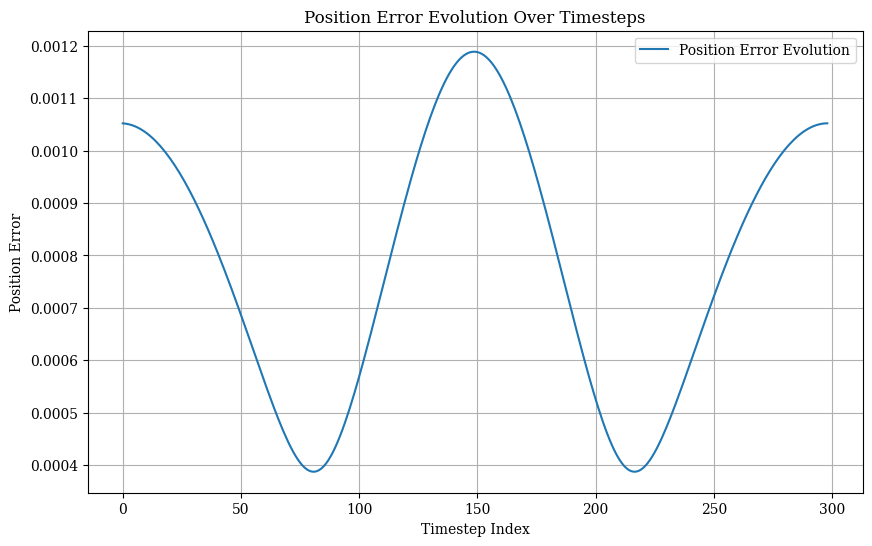

Cumulative velocity error for selected orbits: 0.44235011161515425
Average velocity error per time step: 0.0014794318114219206


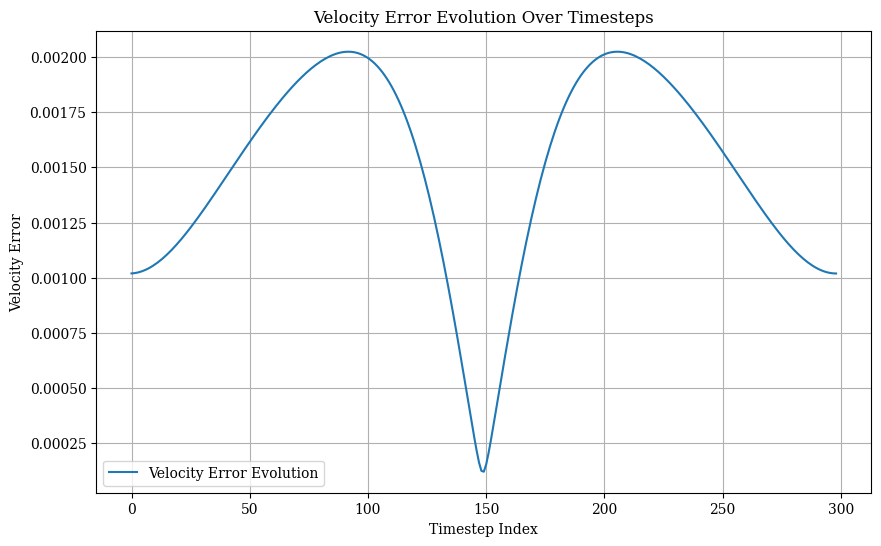

Cumulative energy error for selected orbits: 0.0006821222552635398
Average energy error per time step: 2.2813453353295643e-06


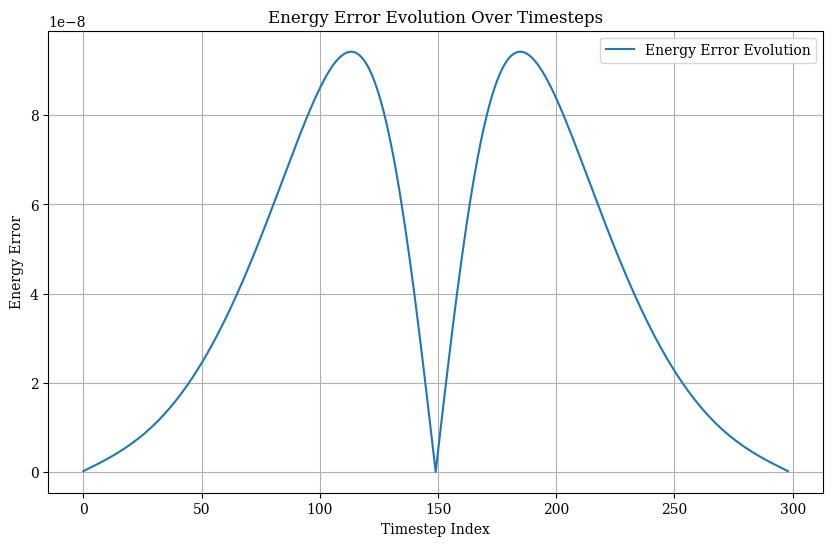

In [68]:
#| test calculate_errors

errors = calculate_errors(orbit_data, EM_MU, orbit_indices = [0, 1, 2], time_step=0.00917391571278981)

In [69]:
#| hide
import nbdev; nbdev.nbdev_export()